This project will take in a dataset and then predict the loss of the other 

### Imports and CUDA

In [58]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Loss Ratio is predicted as 

Loss Ratio=bytes_sent/bytes_retrans​

### Merging all the reno files

In [60]:
# folder_path = "reno"

# # Get a list of all CSV files in the folder
# csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# # Read and merge all CSV files
# df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

# # Concatenate all DataFrames
# merged_df = pd.concat(df_list, ignore_index=True)

# # Save the merged DataFrame to a new CSV file
# merged_df.to_csv(os.path.join(folder_path, "merged_reno.csv"), index=False)

# print("Merging complete. File saved as 'merged_output.csv'.")
# print("merged_reno.csv size: ", merged_df.shape)

# #And then move the file into the root directory

### Preparing the data for RenoCUBIC

I need to normalize the data first, and the continue from there.

In [61]:
import pandas as pd
import numpy as np
import torch

# Load dataset
file_path = "../src/data/cubic_Nich.csv"
df = pd.read_csv(file_path, delimiter=";")

# Convert TCP type to numeric
df['tcp_type'] = df['tcp_type'].map({'reno': 1, 'cubic': 0})


# Identify constant columns
constant_columns = [col for col in df.columns if len(df[col].unique()) == 1]
constant_columns += ["bytes_retrans", "bytes_sent","tcp_type","delivered"]  # Optional if you plan to drop them
#Taking delivered out because that was what was removed last time, because it was all 0. Now, there is value.

# Drop them
df = df.drop(columns=constant_columns)


# 🔹 Separate target before normalization
target_col = "loss_ratio"

features = df.drop(columns=[target_col])



targets = df[[target_col]]  # Keep as DataFrame to match shape

# 🔹 Normalize features and target separately
features_min = features.min()
features_max = features.max()
features_norm = (features - features_min) / (features_max - features_min)

target_min = float(df['loss_ratio'].min())
target_max = float(df['loss_ratio'].max())
targets_norm = (targets - target_min) / (target_max - target_min)

print(features_norm.columns)
print(targets.shape)
print(features.shape)


Index(['wscale', 'rto', 'rtt', 'mss', 'rcvmss', 'advmss', 'cwnd', 'ssthresh',
       'bytes_acked', 'segs_out', 'segs_in', 'data_segs_out', 'lastrcv',
       'rcv_ssthresh', 'timestamp'],
      dtype='object')
(953, 1)
(953, 15)


In [62]:
#As stated in the paper
seq_length = 15
forecast_steps = 15  # Predict the next 15 seconds


def create_sequences(input, labels, seq_length, forecast_steps):
    xs, ys = [], []
    for i in range(len(input) - seq_length - forecast_steps + 1):
        xs.append(input[i : i + seq_length])  # Input sequence
        ys.append(labels[i + seq_length : i + seq_length + forecast_steps])  # Next `forecast_steps` values
    return np.array(xs), np.array(ys)


X, y = create_sequences(features_norm.values, targets_norm['loss_ratio'].values, seq_length, forecast_steps)
data_tensor = torch.tensor(df.values, dtype=torch.float32)
new_X = torch.tensor(X,dtype=torch.float32)
new_y = torch.tensor(y[:,:, None], dtype=torch.float32)
print("Data tensor:", new_X.shape)
print("Loss tensor:", new_y.shape)

Data tensor: torch.Size([924, 15, 15])
Loss tensor: torch.Size([924, 15, 1])


### RenoCubic Sequence Creation

### Splitting the data, 80/10/10

In [63]:
train_size = int(len(new_X) *0.8)
#I remove the first batch because it is just full of zeros,
X_train, X_test = new_X[:train_size], new_X[train_size:]
y_train, y_test = new_y[:train_size], new_y[train_size:]

# Print the shapes to verify the split
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    
    break  # Only print the first batch for verification


torch.Size([739, 15, 15]) torch.Size([185, 15, 15])
torch.Size([739, 15, 1]) torch.Size([185, 15, 1])
Inputs: torch.Size([16, 15, 15]), Targets: torch.Size([16, 15, 1])


###LSTM Model used as the NN.

In [64]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, batch_first = True)
        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, cell_state=None, hidden_state=None):
        # Forward pass through the LSTM cell
        if hidden_state is None or cell_state is None:
            hidden_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
            cell_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        hidden = (cell_state, hidden_state)
        output, new_memory = self.lstm(inputs, hidden)
        cell_state, hidden_state = new_memory
        output = self.linear(output)  # Linear layer on all time steps
        return output, cell_state, hidden_state, # Return correct order

### I will implement sliding window next time, but for now, it will only predict the next value.

In [65]:
def train(model, dataloader, num_epochs, learning_rate):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_values = []

    for epoch in range(num_epochs):
        total_loss = 0  # Track total loss for averaging
        hidden_state, cell_state = None, None  # Reset hidden states for each epoch

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            if batch_idx == len(dataloader) - 1:  
                break  # Skip the last batch

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

            # Compute loss
            loss = criterion(output, targets)
            total_loss += loss.item()  # Sum up the loss for averaging

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Detach hidden states to prevent memory buildup
            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

            # # Print some sample outputs periodically
            # if epoch % 50 == 0 and batch_idx % 50 == 0:
            #     print("Output Sample: ", output[1:5])

        # Print average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
    
    plt.plot(range(num_epochs), loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


In [66]:
import torch
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, num_epochs, learning_rate, target_min, target_max):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        hidden_state, cell_state = None, None

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if batch_idx == len(train_loader) - 1:
                break

            optimizer.zero_grad()
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)
            loss = criterion(output, targets)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        num_batches = 0
        hidden_state, cell_state = None, None

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

                output_denorm = output * (target_max - target_min) + target_min
                target_denorm = targets * (target_max - target_min) + target_min

                loss = criterion(output, targets)
                total_val_loss += loss.item()
                num_batches += 1

                hidden_state = hidden_state.detach()
                cell_state = cell_state.detach()

        avg_val_loss = total_val_loss / num_batches
        val_losses.append(avg_val_loss)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Plot both losses
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses


Epoch 1/200, Train Loss: 0.005066, Val Loss: 0.000216
Epoch 11/200, Train Loss: 0.000700, Val Loss: 0.000068
Epoch 21/200, Train Loss: 0.000538, Val Loss: 0.000031
Epoch 31/200, Train Loss: 0.000475, Val Loss: 0.000015
Epoch 41/200, Train Loss: 0.000447, Val Loss: 0.000010
Epoch 51/200, Train Loss: 0.000424, Val Loss: 0.000012
Epoch 61/200, Train Loss: 0.000413, Val Loss: 0.000019
Epoch 71/200, Train Loss: 0.000389, Val Loss: 0.000034
Epoch 81/200, Train Loss: 0.000216, Val Loss: 0.000029
Epoch 91/200, Train Loss: 0.000252, Val Loss: 0.000042
Epoch 101/200, Train Loss: 0.000106, Val Loss: 0.000047
Epoch 111/200, Train Loss: 0.000084, Val Loss: 0.000088
Epoch 121/200, Train Loss: 0.000118, Val Loss: 0.000137
Epoch 131/200, Train Loss: 0.000079, Val Loss: 0.000181
Epoch 141/200, Train Loss: 0.000077, Val Loss: 0.000192
Epoch 151/200, Train Loss: 0.000077, Val Loss: 0.000191
Epoch 161/200, Train Loss: 0.000071, Val Loss: 0.000183
Epoch 171/200, Train Loss: 0.000065, Val Loss: 0.000176
Epo

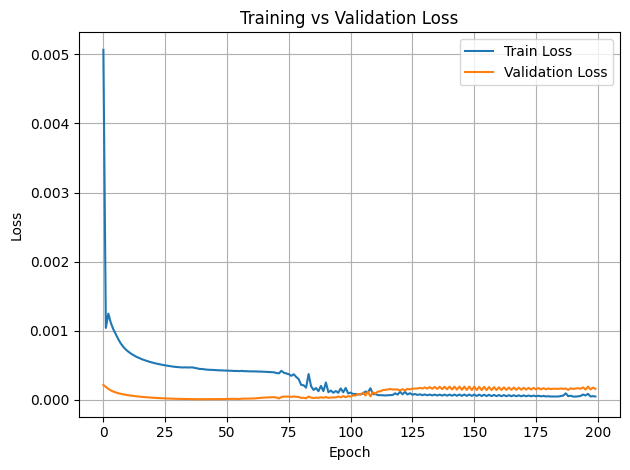

([0.005065789563811082,
  0.0010414358133896307,
  0.0012482272038354533,
  0.0011164672858362888,
  0.0010238975665994618,
  0.0009511510881295296,
  0.0008807324639418128,
  0.0008186626152777574,
  0.0007695188422347085,
  0.0007312892639674828,
  0.0007002339472935691,
  0.0006738607810203053,
  0.000650942242499057,
  0.0006308166765015909,
  0.0006130097974280633,
  0.0005971388509738546,
  0.0005828978467995531,
  0.000570043381753265,
  0.0005583809657919313,
  0.000547751880295688,
  0.0005380266448094304,
  0.0005290961298185798,
  0.00052087192686505,
  0.0005132733654813529,
  0.0005062435244481288,
  0.0004997107672603848,
  0.0004936599817735074,
  0.00048798126311900907,
  0.0004828139964298858,
  0.0004778203651283625,
  0.00047450056539906035,
  0.0004710468414138651,
  0.00046883763584349813,
  0.00047120244008955854,
  0.0004688063126911615,
  0.0004687465364228008,
  0.00047005621206366453,
  0.00046326047302190616,
  0.00045553017221112546,
  0.0004475807155900606,

In [67]:
# Define the model parameters
# Following the research paper's instructions
input_size = 15
hidden_size = 128
num_layers = 1 # Can be changed to stack multiple LSTM layers!
output_size = 1
dataloader = train_loader

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
# train(model, dataloader, num_epochs = 200, learning_rate = 0.001)
train_and_validate(model,train_loader, test_loader, num_epochs = 200, learning_rate = 0.001, target_min = target_min, target_max = target_max)

### Testing the model

In [74]:
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")

print("Total test batches:", len(test_loader))


Batch 0: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 1: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 2: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 3: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 4: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 5: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 6: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 7: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 8: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 9: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Batch 10: Inputs Shape: torch.Size([16, 15, 15]), Targets Shape: torch.Size([16, 15, 1])
Total test batches: 11


Average Validation Loss: 0.0001595572


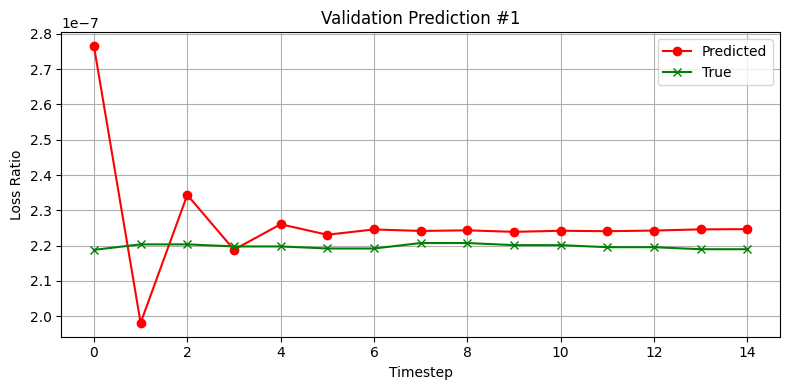

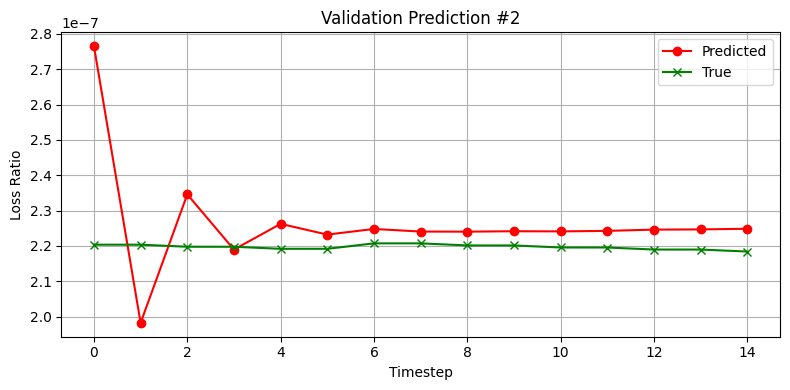

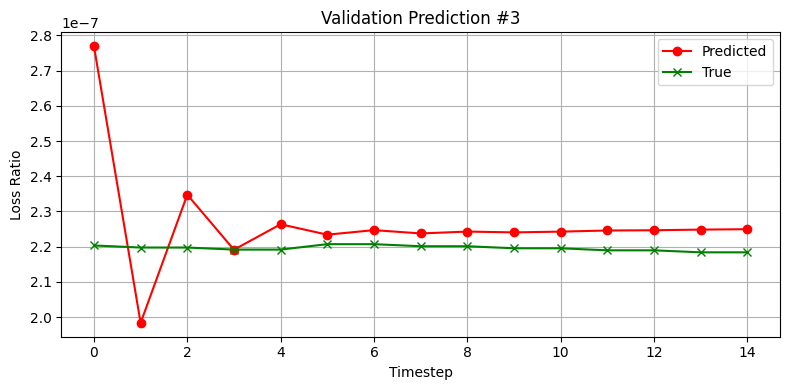

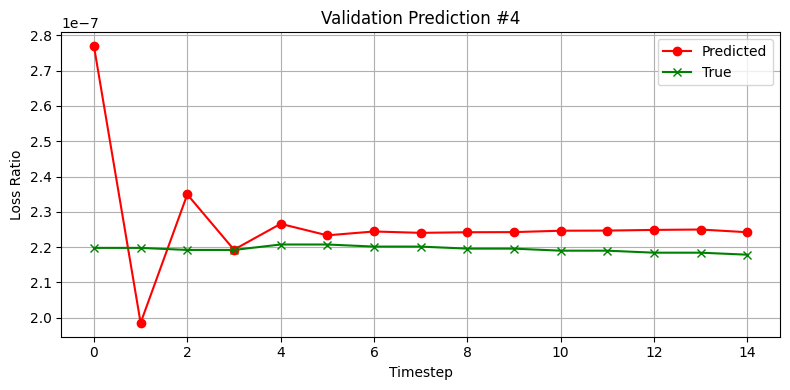

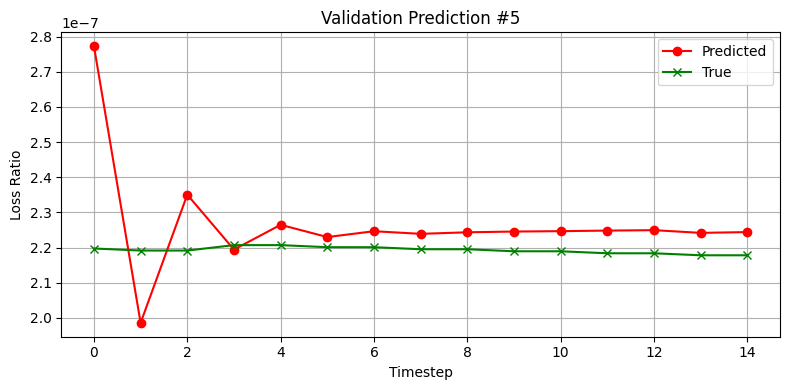

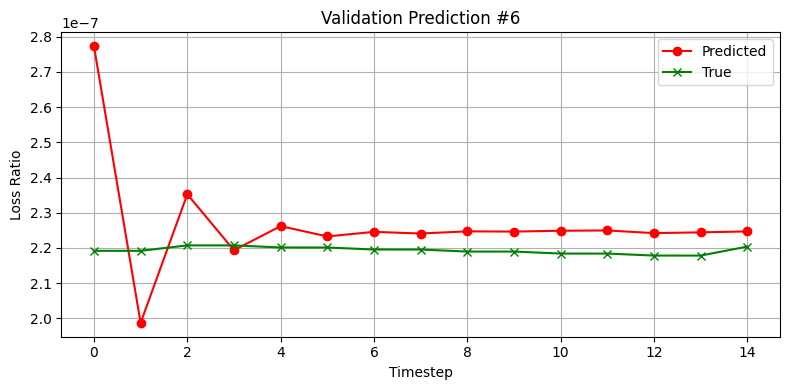

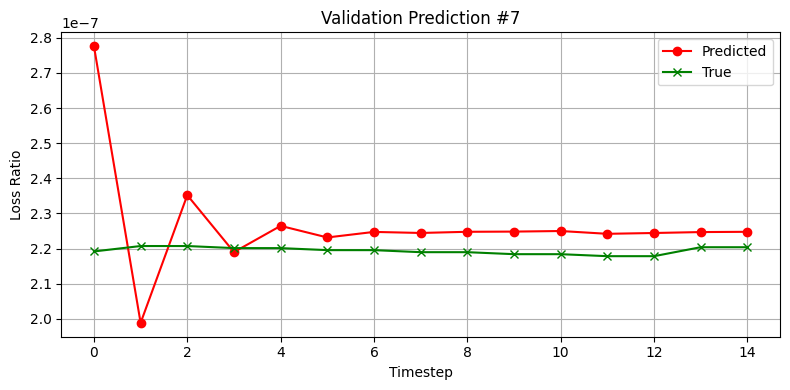

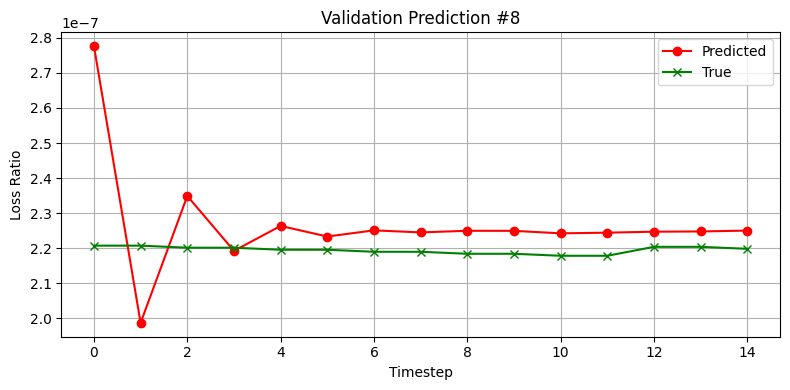

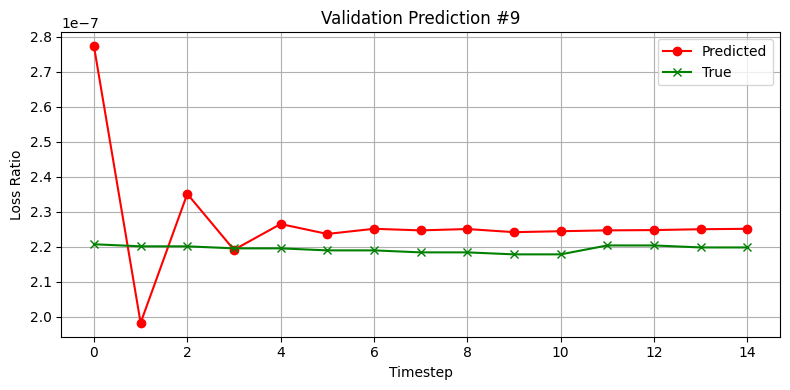

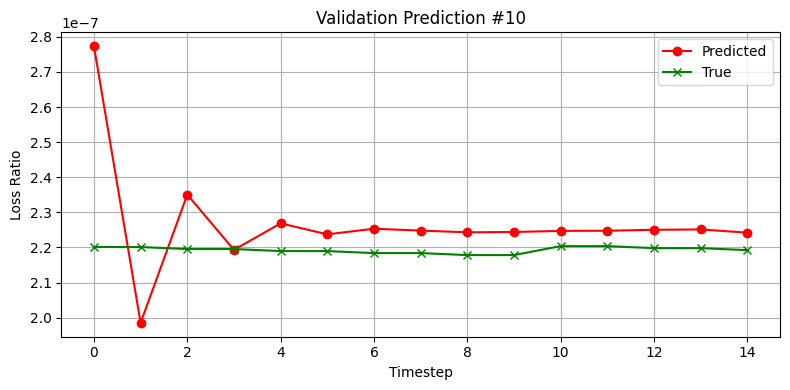

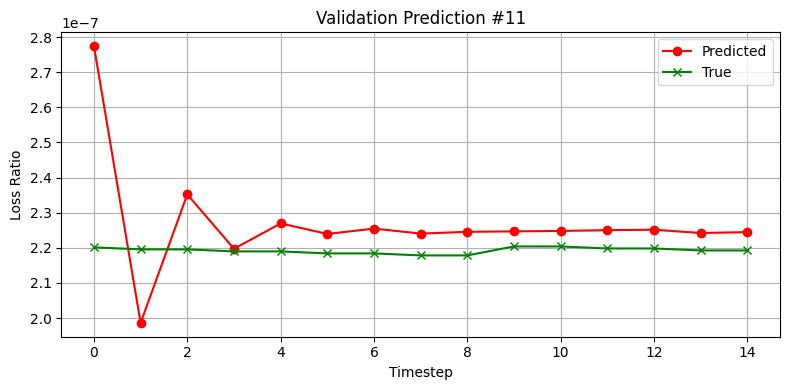

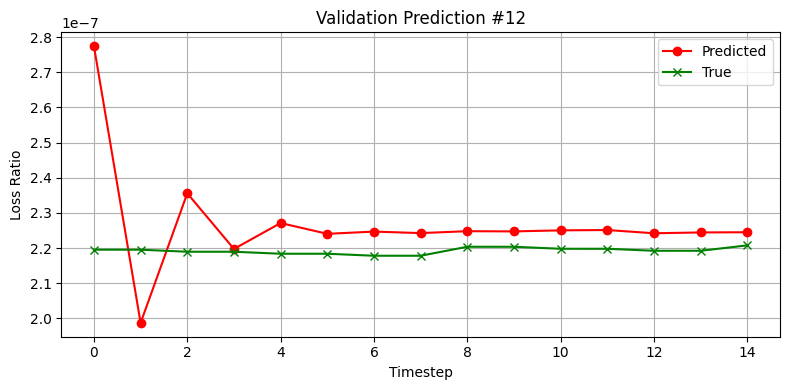

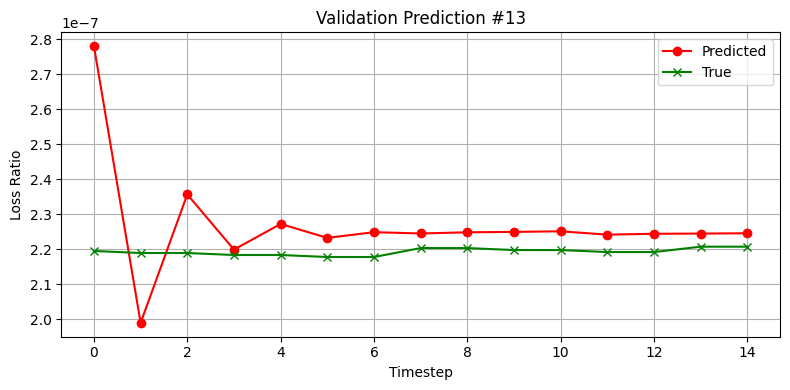

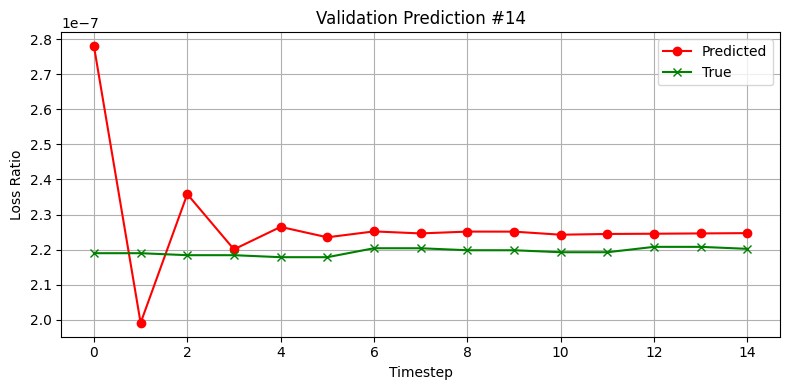

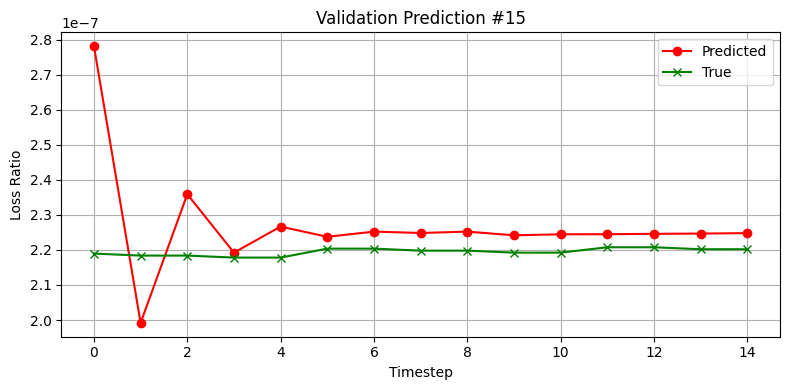

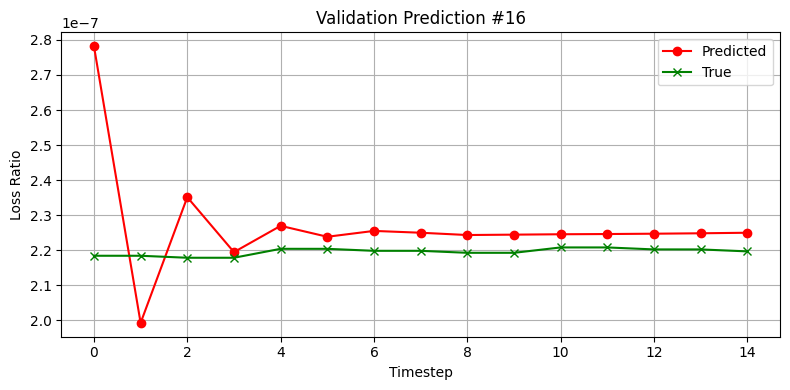

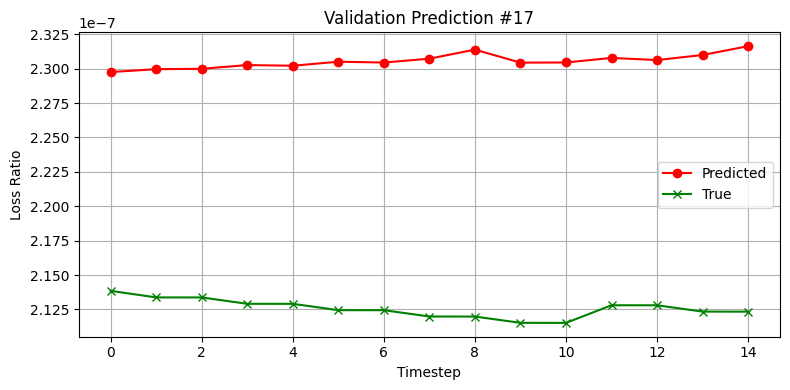

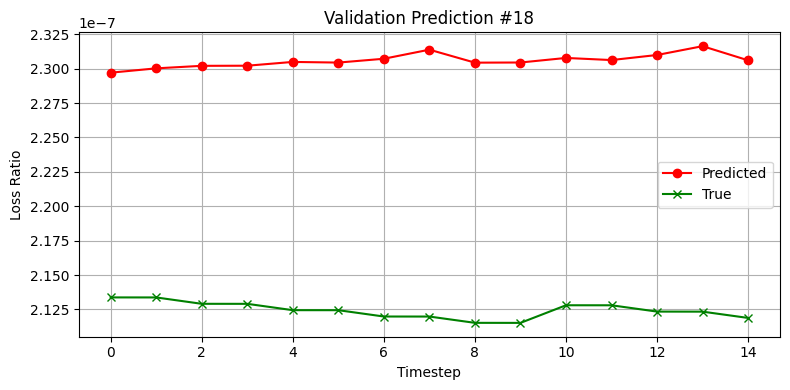

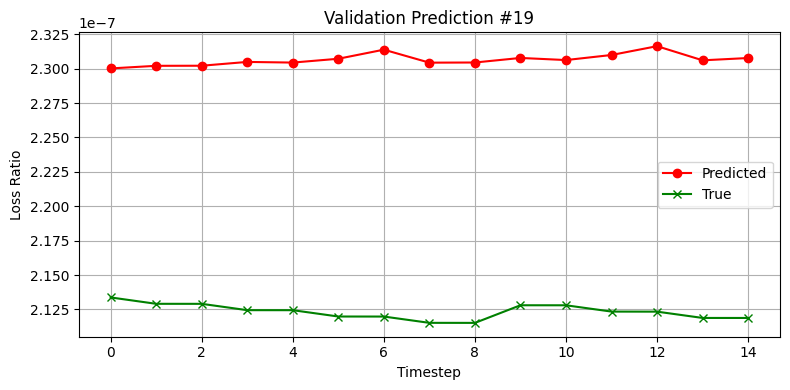

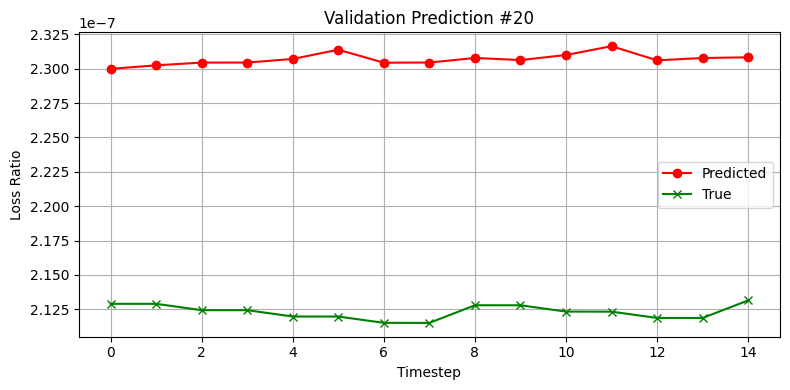

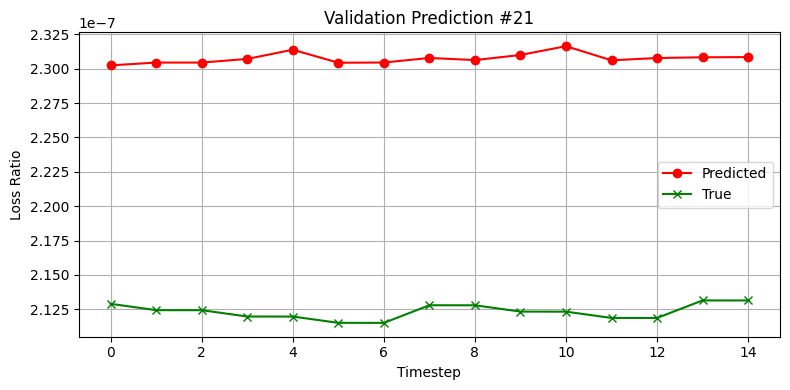

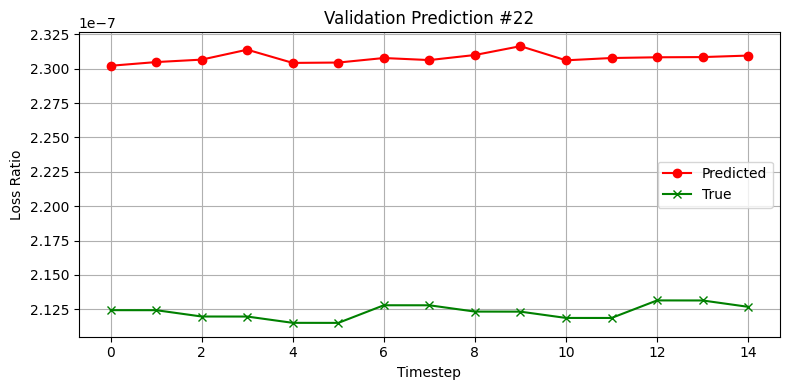

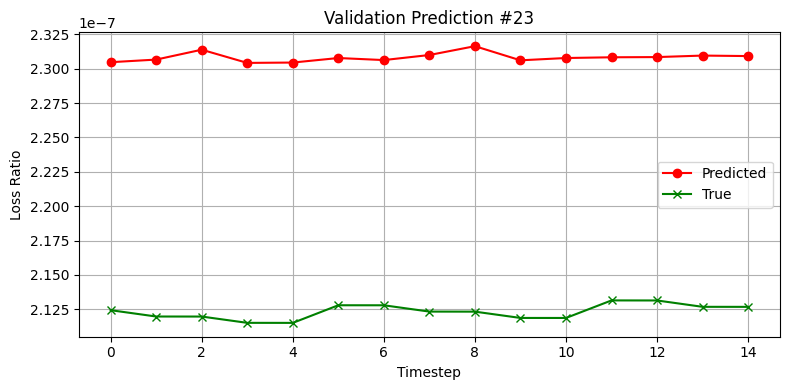

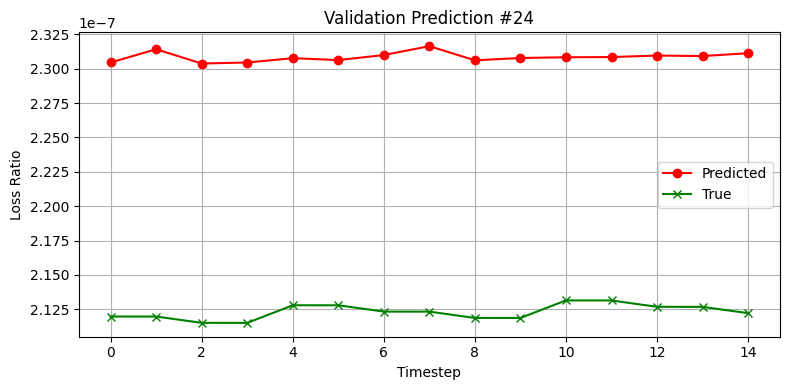

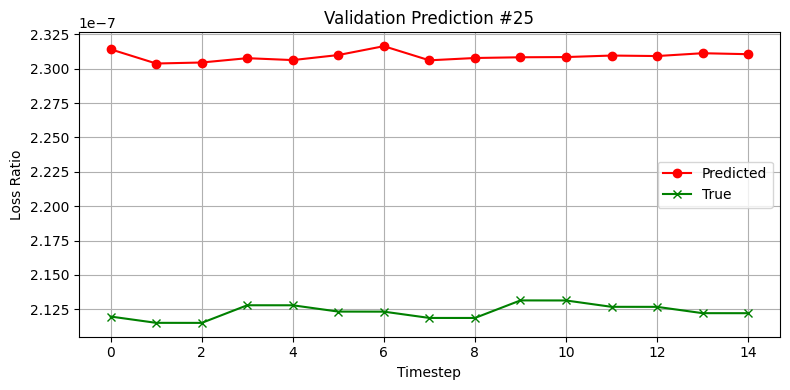

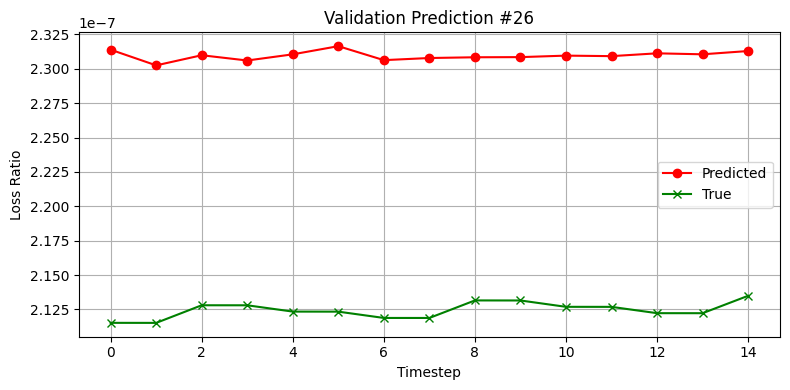

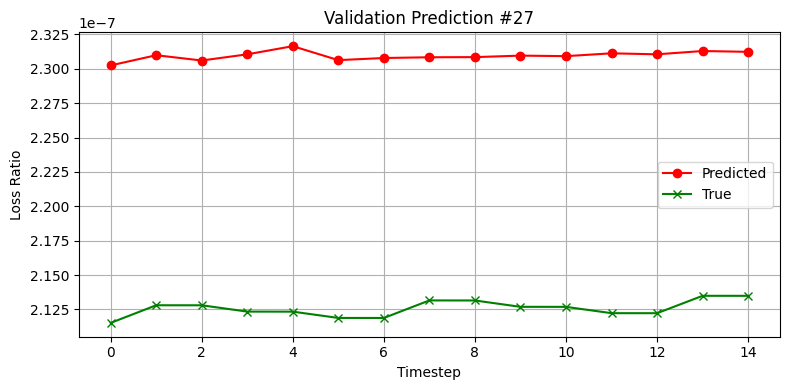

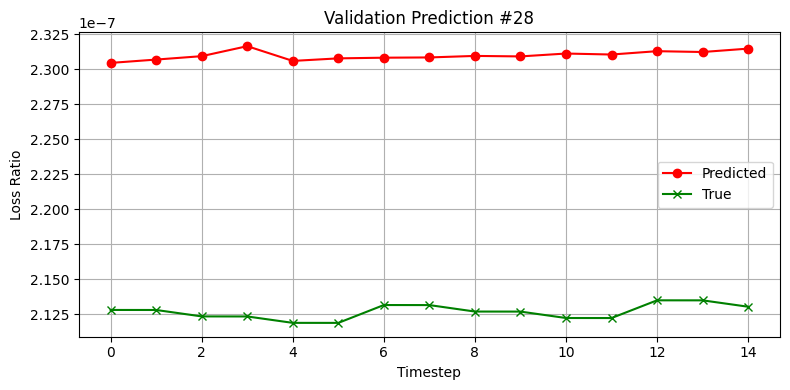

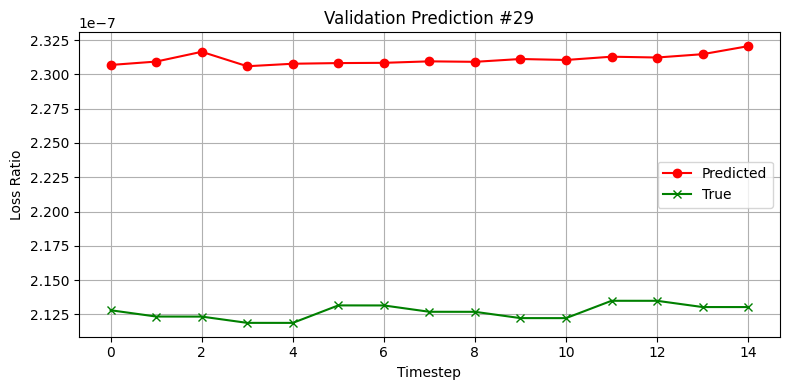

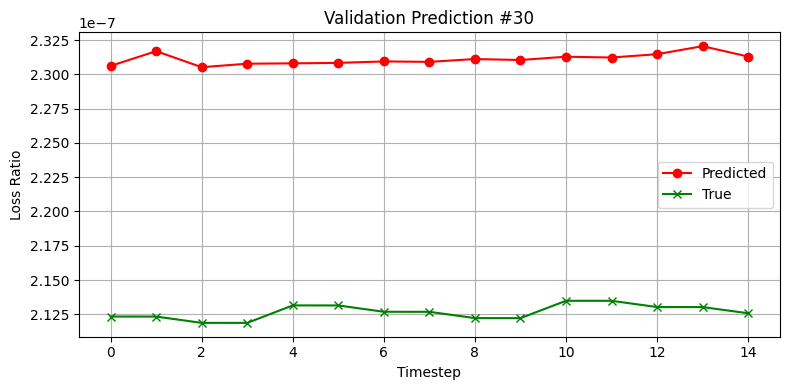

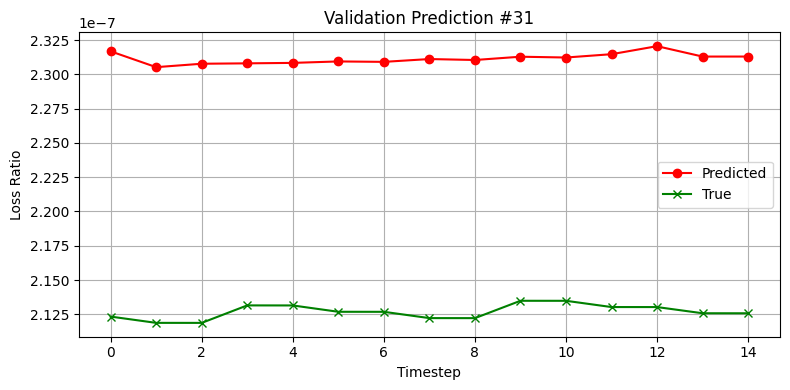

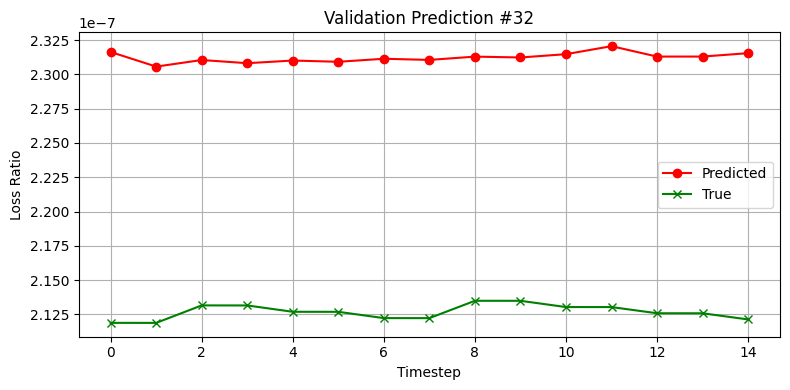

In [75]:
import torch
import matplotlib.pyplot as plt

model.eval()

# Initialize variables to track loss
total_val_loss = 0
num_batches = 0
total_lost_values = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize lists for storing visualized data
predicted_loss_ratios = []
true_loss_ratios = []

# Hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if hidden_state is not None:
            hidden_state = hidden_state.detach()
        if cell_state is not None:
            cell_state = cell_state.detach()

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

        # Denormalize using new min/max for target
        output_denorm = output * (target_max - target_min) + target_min
        target_denorm = targets * (target_max - target_min) + target_min

        # Append each sequence (shape [15,1] -> [15]) as a pair
        if batch_idx % 10 == 0:
            for pred_seq, true_seq in zip(output_denorm.squeeze().cpu(), target_denorm.squeeze().cpu()):
                predicted_loss_ratios.append(pred_seq.numpy())
                true_loss_ratios.append(true_seq.numpy())

        # Compute loss using normalized values
        loss = criterion(output, targets)

        # Accumulate and average loss
        total_val_loss += loss.item()
        total_lost_values.append(total_val_loss / (batch_idx + 1))
        num_batches += 1

# Average loss across all batches
avg_loss = total_val_loss / num_batches
print(f'Average Validation Loss: {avg_loss:.10f}')

# Plot each prediction vs target in separate graphs
for i, (pred, true) in enumerate(zip(predicted_loss_ratios, true_loss_ratios)):
    plt.figure(figsize=(8, 4))
    plt.plot(pred, label='Predicted', color='red', marker='o')
    plt.plot(true, label='True', color='green', marker='x')
    plt.title(f'Validation Prediction #{i+1}')
    plt.xlabel('Timestep')
    plt.ylabel('Loss Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Optional: Limit number of plots if too many
    # if i >= 10: break


In [70]:
print("output size", output.shape)
print("targets size", targets.shape)

output size torch.Size([16, 15, 1])
targets size torch.Size([16, 15, 1])


In [71]:
# Example raw input: [seq_len, num_features] (unnormalized)
# Use one test sequence (unnormalized)
raw_input = X_test[0]  # shape: [15, 12] – already a tensor if you did earlier prep

# Convert to numpy if it's a tensor
raw_input_np = raw_input.numpy()

# Normalize input using feature-wise min and max (excluding loss_ratio)
normalized_input = (raw_input_np - features_min.values) / (features_max.values - features_min.values)
normalized_input = torch.tensor(normalized_input, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, num_features]

# Prepare target loss_ratio min and max (use float)
target_min = float(df['loss_ratio'].min())
target_max = float(df['loss_ratio'].max())

with torch.no_grad():
    hidden_state, cell_state = None, None
    output, _, _ = model(normalized_input, cell_state, hidden_state)

    # Denormalize the output
    output_denorm = output * (target_max - target_min) + target_min

    print("Normalized model output:", output)
    print("Denormalized prediction:", output_denorm)

avg_prediction = output_denorm.mean().item()

print(f"Average Denormalized Prediction: {avg_prediction:.10f}")



Normalized model output: tensor([[[-0.1409],
         [-0.1829],
         [-0.1893],
         [-0.1903],
         [-0.1904],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905],
         [-0.1905]]])
Denormalized prediction: tensor([[[-1.5285e-07],
         [-1.9841e-07],
         [-2.0541e-07],
         [-2.0644e-07],
         [-2.0660e-07],
         [-2.0662e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07],
         [-2.0663e-07]]])
Average Denormalized Prediction: -0.0000002024


In [72]:
def run_RenoCubic(input_30):
    with torch.no_grad():
        hidden_state, cell_state = None, None
        output, _, _ = model(normalized_input, cell_state, hidden_state)

        # Denormalize the output
        output_denorm = output * (target_max - target_min) + target_min

        print("Normalized model output:", output)
        print("Denormalized prediction:", output_denorm)
        avg_prediction = output_denorm.mean().item()
        print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction

def run_Reno(input_30):
    with torch.no_grad():
            hidden_state, cell_state = None, None

            #Change model to renoModel
            output, _, _ = model(normalized_input, cell_state, hidden_state)

            # Denormalize the output
            output_denorm = output * (target_max - target_min) + target_min

            print("Normalized model output:", output)
            print("Denormalized prediction:", output_denorm)
            avg_prediction = output_denorm.mean().item()
            print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction


def run_Cubic(input_30):
    with torch.no_grad():
            hidden_state, cell_state = None, None
            #Change model to cubicModel
            output, _, _ = model(normalized_input, cell_state, hidden_state)

            # Denormalize the output
            output_denorm = output * (target_max - target_min) + target_min

            print("Normalized model output:", output)
            print("Denormalized prediction:", output_denorm)
            avg_prediction = output_denorm.mean().item()
            print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction


def choose_model(model_input, input_30):
    #Reno is 1, cubic is 0
    if model_input == 1:
        avg_RenoCubic_result = run_RenoCubic(input_30)
        avg_Reno_result = run_Reno(input_30)

        if avg_RenoCubic_result > avg_Reno_result:
            return 1
        else:
            return 0

    #CC is cubic
    if model_input == 0:
        avg_RenoCubic_result = run_RenoCubic(input_30)
        avg_Cubic_result = run_Cubic(input_30)

        if avg_RenoCubic_result > avg_Cubic_result:
            return 0
        else:
            return 1




In [73]:
# torch.save(model.state_dict(), "my_model_weights.pth")
# Create a new instance of your model
model = MyModelClass(...)  # Make sure to match architecture

# Load the weights
model.load_state_dict(torch.load("my_model_weights.pth"))

# Set it to evaluation mode if you're using it for inference
model.eval()

NameError: name 'MyModelClass' is not defined